# Introduction
In this notebook we will look at how the popularity of certain shots have changed over time.

# Notebook Objectives
We are interested in one question:
1. How has the popularity of shots changed by season?

# Notes
Later in this notebook I will be using a couple of functions from GitHub user [eyalshafran](https://eyalshafran.github.io/heatmaps.html). The functions `shot_heatmap` and `court` are both fully written by eyalshafran.

# Setup

## Imports

In [73]:
import pandas as pd

import numpy as np

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import matplotlib

import seaborn as sns

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
from scipy import misc

from scipy.ndimage.filters import gaussian_filter
from matplotlib import cm

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc

## Parameters

In [74]:
SHOT_DATASET = '../../../data/processed/210_position_shot_dataset.csv'

## Configuration

In [75]:
sns.set_context('talk')

%matplotlib inline

## Load shots dataset

In [76]:
df = pd.read_csv(SHOT_DATASET)
df.shape, df.nunique()

((2293539, 18),
 GAME_ID                13875
 GAME_EVENT_ID            900
 PLAYER_ID               1338
 PLAYER_NAME             1334
 TEAM_ID                   30
 TEAM_NAME                 30
 SHOT_TYPE                  2
 SHOT_ZONE_BASIC            7
 SHOT_ZONE_AREA             6
 SHOT_ZONE_RANGE            5
 SHOT_DISTANCE             90
 LOC_X                    501
 LOC_Y                    892
 SHOT_ATTEMPTED_FLAG        1
 SHOT_MADE_FLAG             2
 GAME_DATE               1846
 SEASON                    12
 POSITION                   3
 dtype: int64)

In [77]:
df

,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,SEASON,POSITION
0,20900005,140,693,Joe Smith,1610612737,Atlanta Hawks,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,18,106,151,1,0,20091028,2009,F
1,20900005,148,693,Joe Smith,1610612737,Atlanta Hawks,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,17,171,47,1,1,20091028,2009,F
2,20900005,155,693,Joe Smith,1610612737,Atlanta Hawks,2PT Field Goal,Mid-Range,Center(C),16-24 ft.,17,-35,172,1,0,20091028,2009,F
3,20900005,168,693,Joe Smith,1610612737,Atlanta Hawks,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,21,-2,1,1,20091028,2009,F
4,20900005,426,693,Joe Smith,1610612737,Atlanta Hawks,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,-7,71,1,0,20091028,2009,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293534,22000781,427,1629667,Jalen McDaniels,1610612766,Charlotte Hornets,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,23,-230,40,1,0,20210407,2020,NaN
2293535,22000781,431,1629667,Jalen McDaniels,1610612766,Charlotte Hornets,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,7,3,1,1,20210407,2020,NaN
2293536,22000781,442,1629667,Jalen McDaniels,1610612766,Charlotte Hornets,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,40,1,1,1,20210407,2020,NaN
2293537,22000781,622,1629667,Jalen McDaniels,1610612766,Charlotte Hornets,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,-43,-4,1,1,20210407,2020,NaN


# Various Functions
These next two functions are written by GitHub user `eyalshafran`. These functions can be found [here](https://eyalshafran.github.io/heatmaps.html).<br><br>
`shot_heatmap` is used to plot the shots as a heatmap over a basketball court.<br><br>
`court` is used to plot the basketball court.

In [78]:
'''
Author = eyalshafran,
title = NBAapi/plot.py,
year = 2017,
note = last accessed 05/05/2021,
url = https://github.com/eyalshafran/NBAapi/blob/master/NBAapi/plot.py
'''

def shot_heatmap(df,sigma = 1,levels = 20,log=False,player_id=None,zoom=0.5,
                 pic_loc=(19, 37),ax=None,cmap='plasma'):
    '''
    This function plots a heatmap based on the shot chart.
    input - dataframe with x and y coordinates.
    optional - log (default false) plots heatmap in log scale. 
               player (default true) adds player's picture and name if true 
               sigma - the sigma of the Gaussian kernel. In feet (default=1)
    '''
    n,_,_ = np.histogram2d( 0.1*df['LOC_X'].values, 0.1*df['LOC_Y'].values,bins = [500,500],range = [[-25,25],[-5.25,44.75]])
    N = gaussian_filter(n,10.0*sigma)
    if log:
        N = np.log(N)
    ccmap = cm.get_cmap(cmap,levels)
    ccmap.set_bad('white')
    if ax is None:
        ax = plt.gca(xlim = [30,-30],ylim = [-7,43],xticks=[],yticks=[],aspect=1.0)
    court(ax,outer_lines=True,color='black',lw=2.0,direction='down')
    ax.axis('off')
    ax.imshow(np.rot90(N),cmap=ccmap,extent=[-25.0, 25.0, -5.25, 44.75])
        
    return ax

In [79]:
'''
Author = eyalshafran,
title = NBAapi/plot.py,
year = 2017,
note = last accessed 05/05/2021,
url = https://github.com/eyalshafran/NBAapi/blob/master/NBAapi/plot.py
'''

def court(ax=None, color='black', lw=4, outer_lines=False,direction='up',short_three=False):
    '''
    Plots an NBA court
    outer_lines - accepts False or True. Plots the outer side lines of the court.
    direction - 'up' or 'down' depending on how you like to view the court
    Original function from http://savvastjortjoglou.com/
    '''
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        if direction=='up':
            ax = plt.gca(xlim = [-30,30],ylim = [43,-7],xticks=[],yticks=[],aspect=1.0)
            plt.text(22,44,'By: Doingthedishes',color='black',horizontalalignment='center',fontsize=20,fontweight='bold')
        elif direction=='down':
            ax = plt.gca(xlim = [30,-30],ylim = [-7,43],xticks=[],yticks=[],aspect=1.0)
            plt.text(-22,-7,'By: Doingthedishes',color='black',horizontalalignment='center',fontsize=20,fontweight='bold')
        else:
            ax = plt.gca()
    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 1.5 
    hoop = Circle((0, 0), radius=0.75, linewidth=lw/2, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-3, -0.75), 6, -0.1, linewidth=lw, color=color)

    # The paint
    # Create the outer box of the paint, width=16ft, height=19ft
    outer_box = Rectangle((-8, -5.25), 16, 19, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-6, -5.25), 12, 19, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 13.75), 12, 12, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 13.75), 12, 12, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 8, 8, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    if not short_three:
        corner_three_a = Rectangle((-22, -5.25), 0, np.sqrt(23.75**2-22.0**2)+5.25, linewidth=lw,
                                   color=color)
        corner_three_b = Rectangle((22, -5.25), 0, np.sqrt(23.75**2-22.0**2)+5.25, linewidth=lw, color=color)
        # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
        three_arc = Arc((0, 0), 47.5, 47.5, theta1=np.arccos(22/23.75)*180/np.pi, theta2=180.0-np.arccos(22/23.75)*180/np.pi, linewidth=lw,
                        color=color)
    else:
        corner_three_a = Rectangle((-22, -5.25), 0, 5.25, linewidth=lw,
                           color=color)
        corner_three_b = Rectangle((22, -5.25), 0, 5.25, linewidth=lw, color=color)
        # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
        three_arc = Arc((0, 0), 44.0, 44.0, theta1=0, theta2=180, linewidth=lw,
                        color=color)
        # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc]  

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-25, -5.25), 50, 46.75, linewidth=lw,
                                color=color, fill=False)
        center_outer_arc = Arc((0, 41.25), 12, 12, theta1=180, theta2=0,
                                linewidth=lw, color=color)
        center_inner_arc = Arc((0, 41.25), 4, 4, theta1=180, theta2=0,
                                linewidth=lw, color=color)
        court_elements = court_elements + [outer_lines,center_outer_arc,center_inner_arc]
    else:
        ax.plot([-25,25],[-5.25,-5.25],linewidth=lw,color=color)
    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)
#    ax.axis('off')
    return ax


# First graph

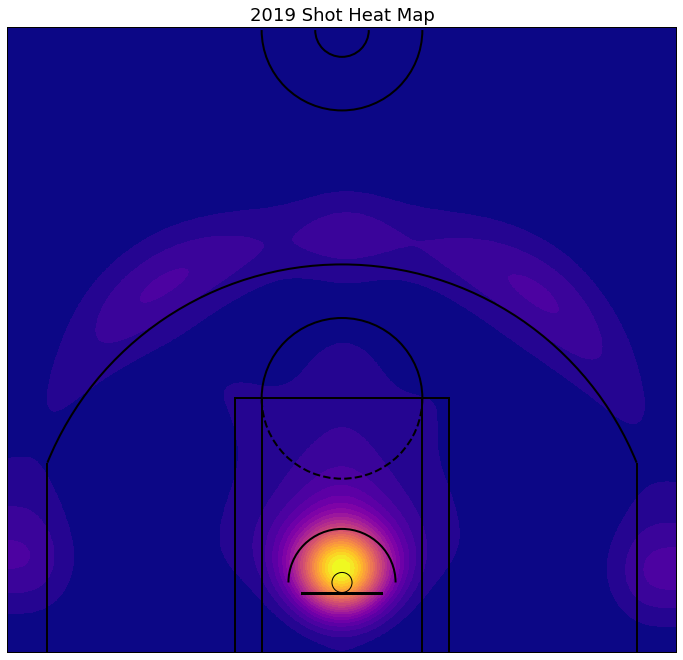

In [80]:
sc = df[(df['SEASON']==2019)].copy()
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc,sigma=2, levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("2019 Shot Heat Map")
plt.savefig('../../../graphs/2100_restricted_area_popularity.png')

# Final graphs
As you can see from the graph above the restricted area is by far the most popular shot location, this holds true accross all seasons. To make it easier to see how other shots have changed in popularity we will filter all shots from the restricted area.

# 2009 vs 2019

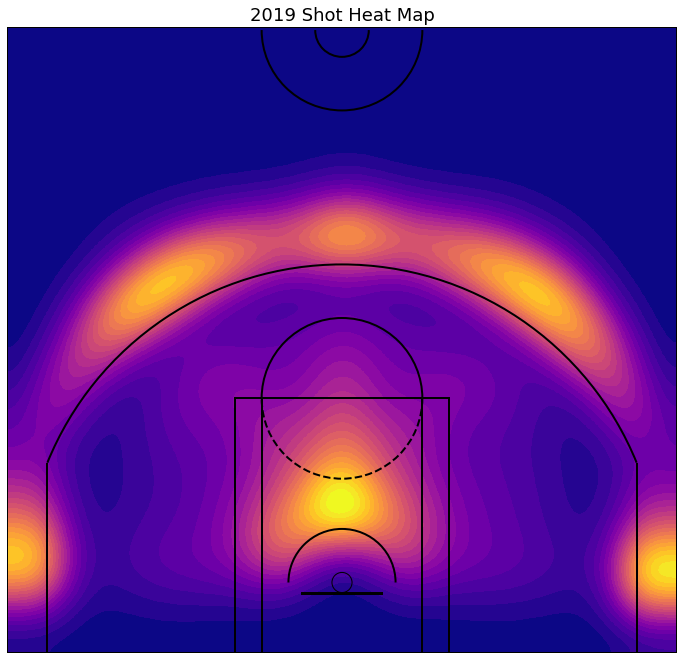

In [81]:
sc = df[(df['SEASON']==2019) & (df['SHOT_ZONE_BASIC']!='Restricted Area')].copy()
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc,sigma=2, levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("2019 Shot Heat Map")
plt.savefig('../../../graphs/2100_popular_ranges_2019.png')

In [82]:
sc1 = df[(df['SEASON']==2009) & (df['SHOT_ZONE_BASIC']!='Restricted Area')].copy()

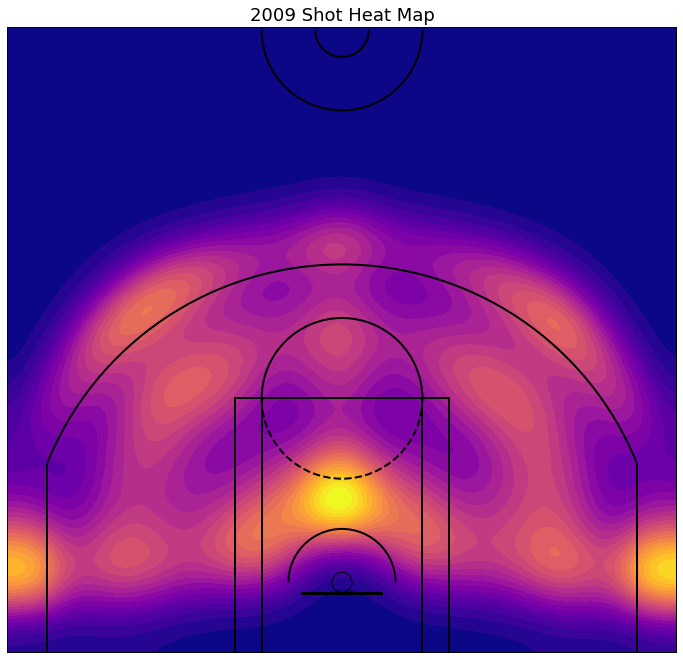

In [83]:
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc1,sigma=2,levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("2009 Shot Heat Map")
plt.savefig('../../../graphs/2100_popular_ranges_2009.png')

# Stephen Curry and his influence
As I have mentioned in previous notebooks, I believe Steph Curry is responsible for the massive popularity of the 3 point shot. Let's visualise the shots he took in his [unanimous MVP season (2015-16)](https://www.nbcsports.com/northwest/nba/steph-curry-becomes-first-unanimous-mvp-nba-history).

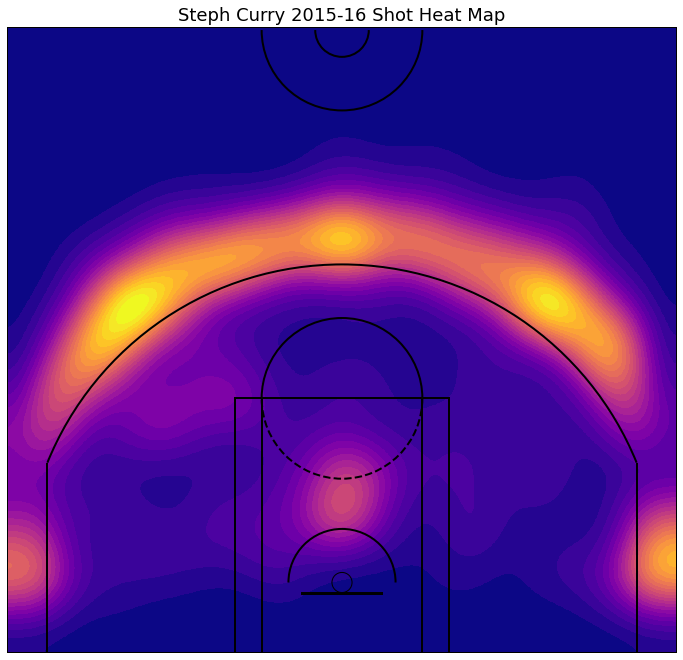

In [84]:
sc = df[(df['SEASON']==2015) & (df['PLAYER_NAME']=='Stephen Curry') & (df['SHOT_ZONE_BASIC']!='Restricted Area')].copy()
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc,sigma=2, levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("Steph Curry 2015-16 Shot Heat Map")
plt.savefig('../../../graphs/2100_Curry_favourite_shots_2015.png');

## The Influence

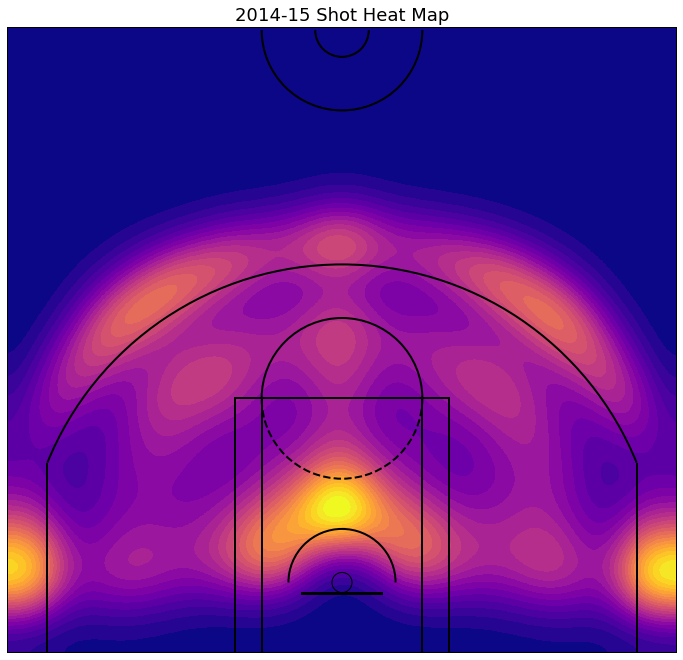

In [85]:
sc = df[(df['SEASON']==2014) & (df['SHOT_ZONE_BASIC']!='Restricted Area')].copy()
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc,sigma=2, levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("2014-15 Shot Heat Map")
plt.savefig('../../../graphs/2100_popular_ranges_2014.png');

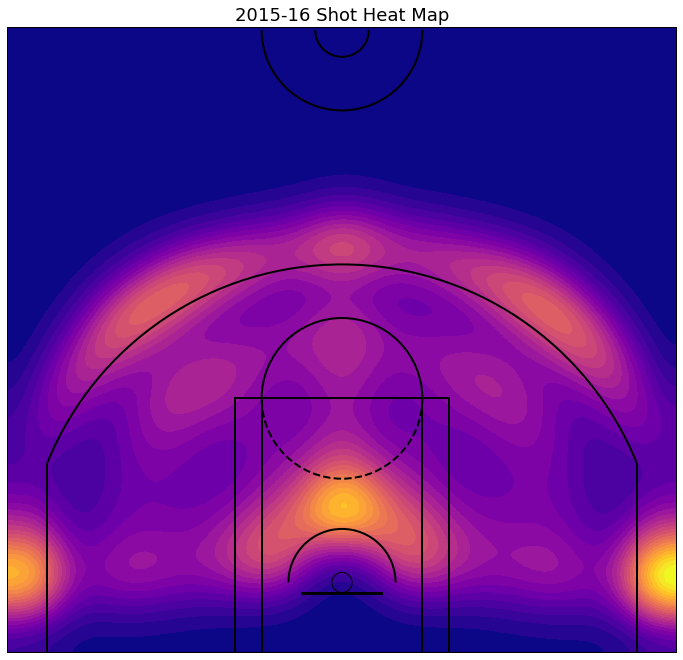

In [86]:
sc = df[(df['SEASON']==2015) & (df['SHOT_ZONE_BASIC']!='Restricted Area')].copy()
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc,sigma=2, levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("2015-16 Shot Heat Map")
plt.savefig('../../../graphs/2100_popular_ranges_2015.png');

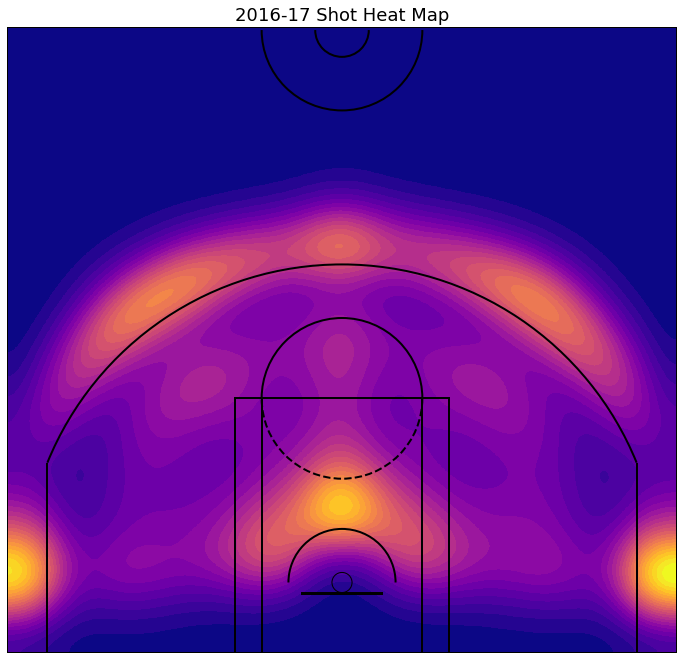

In [87]:
sc = df[(df['SEASON']==2016) & (df['SHOT_ZONE_BASIC']!='Restricted Area')].copy()
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc,sigma=2, levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("2016-17 Shot Heat Map")
plt.savefig('../../../graphs/2100_popular_ranges_2016.png');

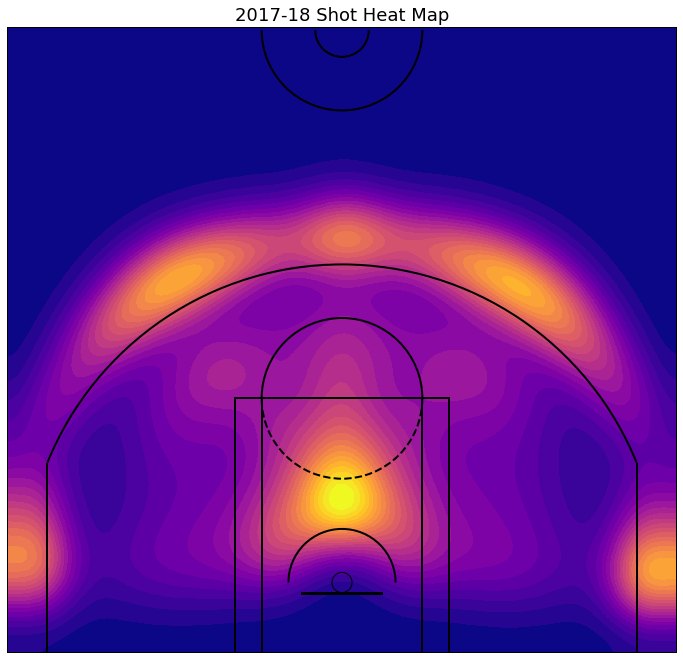

In [88]:
sc = df[(df['SEASON']==2017) & (df['SHOT_ZONE_BASIC']!='Restricted Area')].copy()
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc,sigma=2, levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("2017-18 Shot Heat Map")
plt.savefig('../../../graphs/2100_popular_ranges_2017.png');

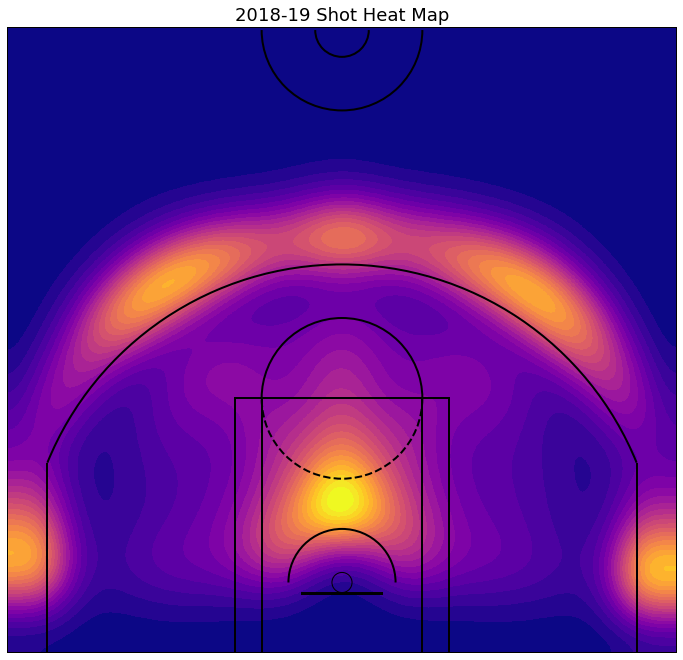

In [91]:
sc = df[(df['SEASON']==2018) & (df['SHOT_ZONE_BASIC']!='Restricted Area')].copy()
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc,sigma=2, levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("2018-19 Shot Heat Map")
plt.savefig('../../../graphs/2100_popular_ranges_2018.png');

# Shots by Position
Players in different positions take different kinds of shots.

# Guards

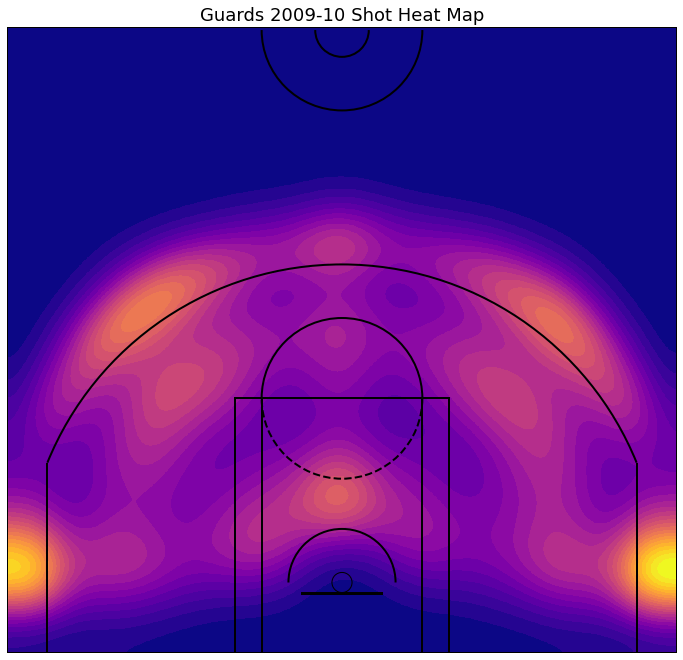

In [92]:
sc = df[(df['SEASON']==2009) & (df['SHOT_ZONE_BASIC']!='Restricted Area') & (df['POSITION']=='G')].copy()
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc,sigma=2, levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("Guards 2009-10 Shot Heat Map")
plt.savefig('../../../graphs/2100_Guards_popular_ranges_2009.png');

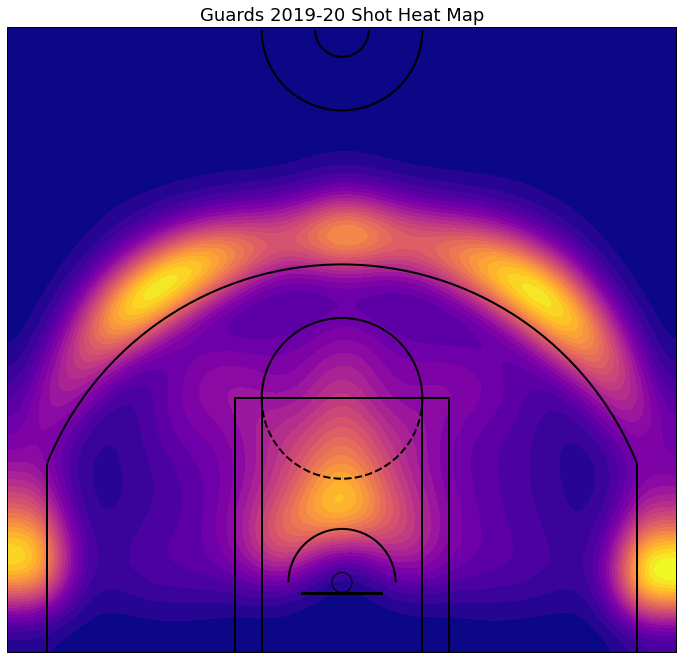

In [67]:
sc = df[(df['SEASON']==2019) & (df['SHOT_ZONE_BASIC']!='Restricted Area') & (df['POSITION']=='G')].copy()
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc,sigma=2, levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("Guards 2019-20 Shot Heat Map")
plt.savefig('../../../graphs/2100_Guards_popular_ranges_2019.png');

# Forwards

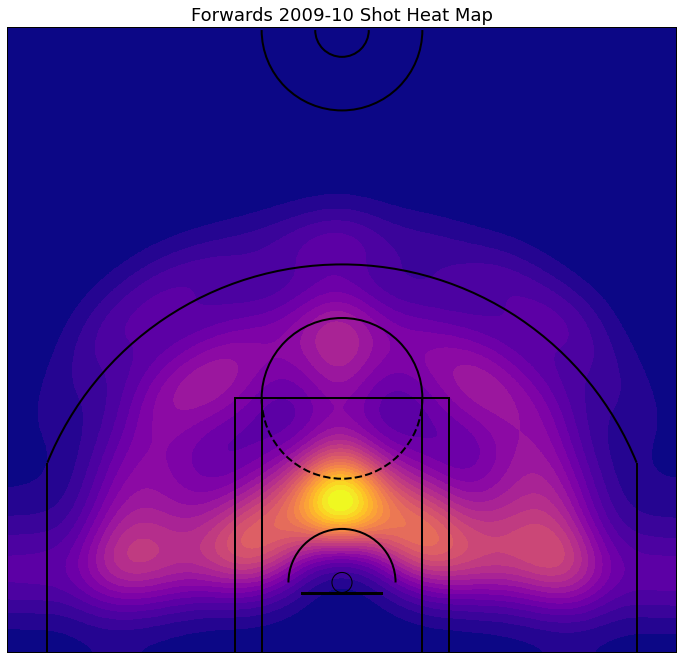

In [68]:
sc = df[(df['SEASON']==2009) & (df['SHOT_ZONE_BASIC']!='Restricted Area') & (df['POSITION']=='F')].copy()
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc,sigma=2, levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("Forwards 2009-10 Shot Heat Map")
plt.savefig('../../../graphs/2100_Forwards_popular_ranges_2009.png');

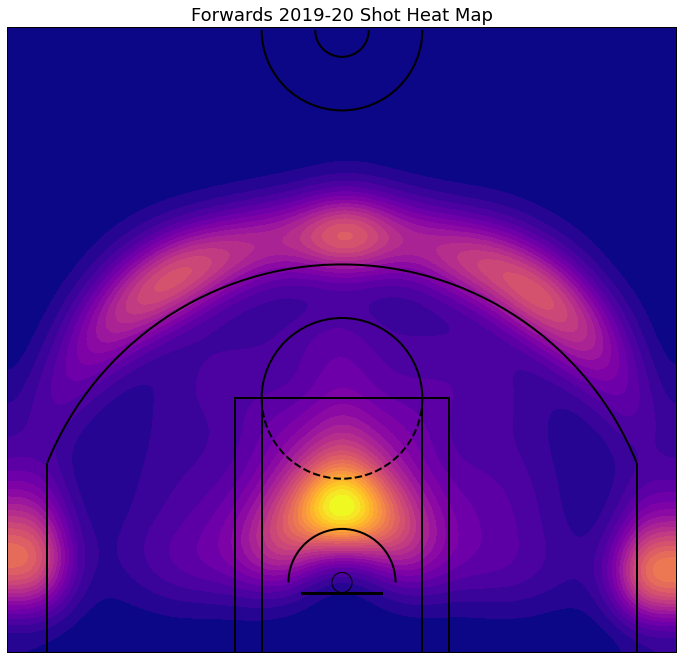

In [69]:
sc = df[(df['SEASON']==2019) & (df['SHOT_ZONE_BASIC']!='Restricted Area') & (df['POSITION']=='F')].copy()
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc,sigma=2, levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("Forwards 2019-20 Shot Heat Map")
plt.savefig('../../../graphs/2100_Forwards_popular_ranges_2019.png');

# Centers

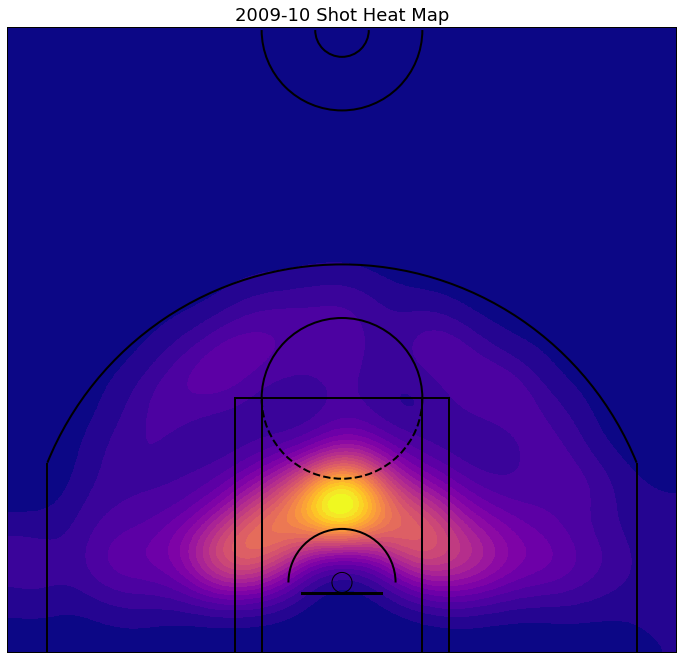

In [70]:
sc = df[(df['SEASON']==2009) & (df['SHOT_ZONE_BASIC']!='Restricted Area') & (df['POSITION']=='C')].copy()
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc,sigma=2, levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("2009-10 Shot Heat Map")
plt.savefig('../../../graphs/2100_Centers_popular_ranges_2009.png');

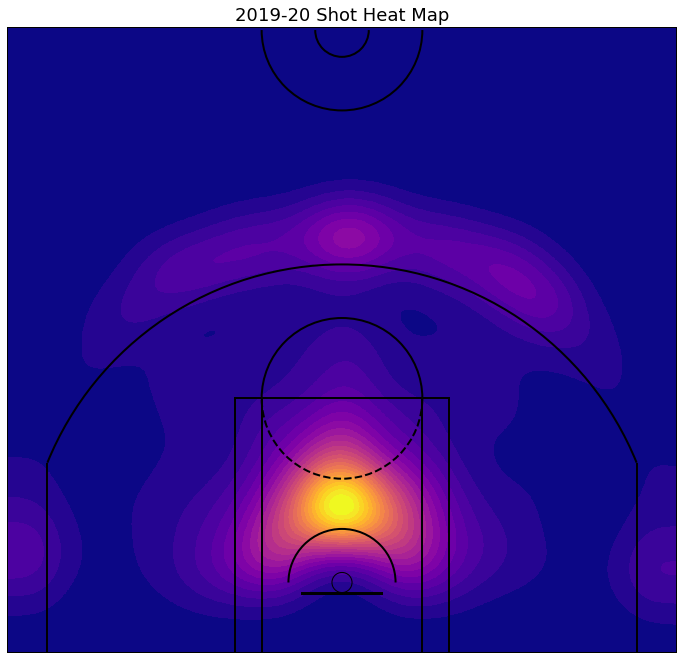

In [71]:
sc = df[(df['SEASON']==2019) & (df['SHOT_ZONE_BASIC']!='Restricted Area') & (df['POSITION']=='C')].copy()
plt.figure(figsize=(12,12))
ax = shot_heatmap(sc,sigma=2, levels = 25, log=False)
ax.set_xlim(25.0,-25.0)
ax.set_ylim(-5.25,41.50)
plt.title("2019-20 Shot Heat Map")
plt.savefig('../../../graphs/2100_Centers_popular_ranges_2019.png');

# Clear dataframes
This project contains many dataframes. To make sure we don't run out of memory we will delete our dataframes at the end of each notebook.

In [93]:
%reset -f